# Overview
We constructed a linear regression model through an iterative process to determine how house characteristics correlated with sale price. The model was trained and tested on a dataset containing 21,597 sales of houses in King County, Washington from May 2014 to May 2015. This model can be used by real estate companies, such as Every Door Real Estate, to determine appropriate housing prices from a house's features. Setting the right price for a house can improve sales and comissions for that company. We used recursive feature elimination with cross-validation to decide which features to include in our model. Our final model had an $R^{2}$ of 0.80, explaining of the variance in price. The RMSE, the average error of our model in units of price, was $161,112. Two of our key measures were renovations and home condition. All else held equal, a house that has been renovated has a mean price of \\$20,000 greater than houses that were not renovated. All else held equal, a house in very good condition has a mean price of \\$54,000 greater than average. 

# Business Problem

In the housing market, home sellers and realtors have different goals. A seller's ultimate goal is to sell the house at the highest price. A real estate agent's goal is to sell a higher volume of properties in order to maximize commissions. There is a fine balance between these two goals: the agent aims to sell the property as quickly as possible, but at a high enough value to satisfy their client. A realistic understanding of home prices is a necessity to optimize this tradeoff.

Our client is Every Door Real Estate, a real estate company in Seattle, Washington. Every Door Real Estate represents individuals selling their moderately price homes. This project aims at developing a linear regression model to help Every Door understand how different home features correlate with home prices. The model is constructed using historical home sales in King County, Washington. Every Door can use this model to determine an appropriate range of values for a home based upon its characteristics. This information can be used to determine how much a home is valued on the market and whether a home seller is over- or under-valuing their property.

# Data Understanding
For this analysis, we will utilize the "King County Housing Price from May 2014- May 2015" created by the Center for Spatial Data Science (https://spatial.uchicago.edu). It contains 21,597 entries with 21 different columns about home sales in the Seattle metropolitan area. We've included some descriptive statistics. This dataset provides us with information suitable for linear regression analysis to predict home prices in the Seattle metroplitan area. This robust dataset contains information about previous home selling prices along with multiple features of the home at time of sale. One limitation of this dataset - is that it represents a single year of data, another limitation is that it isnt current data. Ideally to make relevant and accurate predictions we'd need data that is current. Even if this data is not particularly useful at captuing current market trends, it is still useful at helping us evaluate if linear regression is a good fit to model these relationships.

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
#from random import gauss
#from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
#ignore pairplot and graph warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
housing = pd.read_csv('data/kc_house_data.csv')
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [6]:
housing.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Observations: 

- We have several columns with categorical values:
    1. waterfront      
    2. view             
    3. condition       
    4. grade           
    5. zipcode
    
    

- Also the column sqft_basement is an object. Using our domain knowledge - we feel that it should be numerical.
  We'll take a look at this in the next section.

- We have several null values in the waterfont and yr_renovated columns. Yr_renovated seems self-explanatory - a         null value means that the house was not renovated. 
- We have a small number of null values in the view column.  
- In the next section we'll explore these columns - waterfront, view, sqft_basement, and yr_renovated columns
  along with a few other columns to try and prepare our data for further analysis.


# Data Preparation 
In this section we'll examine several of our columns and try to clean them up in order to analyse them further.
We'll figure out how to handle null values in several of our columns, ensure the minimum and maximum values are what we expect for columns that contain a measurement of time, and investigate our 'id' column to take a look at instances
where the id is duplicated. We'll also ensure the columns are in appropriate data types.


In [7]:
#examining response values in the waterfront column
print(housing['waterfront'].isna().sum())
housing['waterfront'].value_counts()

2376


NO     19075
YES      146
Name: waterfront, dtype: int64

In [8]:
#taking a look at instances where we have a null value in waterfront and a "NONE" value in the view category
housing[(housing['waterfront'].isna()) & (housing['view'] == "NONE")]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
10,1736800520,4/3/2015,662500.0,3,2.50,3560,9796,1.0,NaN,NONE,...,8 Good,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925
23,8091400200,5/16/2014,252700.0,2,1.50,1070,9643,1.0,NaN,NONE,...,7 Average,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
40,5547700270,7/15/2014,625000.0,4,2.50,2570,5520,2.0,NaN,NONE,...,9 Better,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
55,9822700295,5/12/2014,885000.0,4,2.50,2830,5000,2.0,NaN,NONE,...,9 Better,2830,0.0,1995,0.0,98105,47.6597,-122.290,1950,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21567,2025049203,6/10/2014,399950.0,2,1.00,710,1157,2.0,NaN,NONE,...,7 Average,710,0.0,1943,0.0,98102,47.6413,-122.329,1370,1173
21578,5087900040,10/17/2014,350000.0,4,2.75,2500,5995,2.0,NaN,NONE,...,8 Good,2500,0.0,2008,0.0,98042,47.3749,-122.107,2530,5988
21586,844000965,6/26/2014,224000.0,3,1.75,1500,11968,1.0,NaN,NONE,...,6 Low Average,1500,0.0,2014,0.0,98010,47.3095,-122.002,1320,11303
21587,7852140040,8/25/2014,507250.0,3,2.50,2270,5536,2.0,NaN,NONE,...,8 Good,2270,0.0,2003,0.0,98065,47.5389,-121.881,2270,5731


In [9]:
#filling in 'NO' for null values in our waterfront column
housing['waterfront'].fillna(value='NO', inplace=True)

In [10]:
#454 columns with '?' for a value. That explains why the data type came up as an object
housing['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
20.0          1
2180.0        1
556.0         1
2570.0        1
2190.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [11]:
# create new column sqrt_basement2 which is sqrt_living - sqrt-above. Addresses sqft_basement ? values.
housing['sqft_basement2'] = housing['sqft_living'] - housing['sqft_above']
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,910
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0


In [12]:
# has 3842 nan values, also has some 0.0 values
print(housing['yr_renovated'].isna().sum())
housing['yr_renovated'].value_counts()

3842


0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [13]:
#creating new column "was_renovated". Assuming Nan value and 0.0 - means home was not renovated.
housing['yr_renovated'].fillna(0, inplace=True)
housing['was_renovated'] = housing['yr_renovated'] != 0.0

In [14]:
#replacing 0.0 in yr_renovated column with associated value in yr_built
housing.loc[housing['yr_renovated'] == 0, ['yr_renovated']] = housing['yr_built']

In [15]:
#sanity check
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,0,False
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400,True
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,0,False
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,910,False
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,0,False


In [16]:
#taking a look at the 63 null values in the view column
print(housing['view'].isna().sum())
housing['view'].value_counts()

63


NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [17]:
#assuming a value of "NONE" for nulls in the view column
housing['view'].fillna(value='NONE', inplace=True)

In [18]:
#investigating outlier bedrooms
housing[housing['bedrooms'] > 8]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
4092,1997200215,5/7/2014,599999.0,9,4.50,3830,6988,2.5,NO,NONE,...,1380.0,1938,1938.0,98103,47.6927,-122.338,1460,6291,1380,False
4231,2902200015,1/6/2015,700000.0,9,3.00,3680,4400,2.0,NO,NONE,...,850.0,1908,1908.0,98102,47.6374,-122.324,1960,2450,850,False
6073,9822700190,8/8/2014,1280000.0,9,4.50,3650,5000,2.0,NO,NONE,...,1120.0,1915,2010.0,98105,47.6604,-122.289,2510,5000,1120,True
8537,424049043,8/11/2014,450000.0,9,7.50,4050,6504,2.0,NO,NONE,...,0.0,1996,1996.0,98144,47.5923,-122.301,1448,3866,0,False
8748,1773100755,8/21/2014,520000.0,11,3.00,3000,4960,2.0,NO,NONE,...,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,600,True
13301,627300145,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,NO,AVERAGE,...,2090.0,2008,2008.0,98004,47.5861,-122.113,2730,10400,2090,False
15147,5566100170,10/29/2014,650000.0,10,2.00,3610,11914,2.0,NO,NONE,...,600.0,1958,1958.0,98006,47.5705,-122.175,2040,11914,600,False
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,NO,NONE,...,580.0,1947,1947.0,98103,47.6878,-122.331,1330,4700,580,False
16830,8823900290,3/17/2015,1400000.0,9,4.00,4620,5508,2.5,NO,NONE,...,750.0,1915,1915.0,98105,47.6684,-122.309,2710,4320,750,False
18428,8823901445,3/13/2015,934000.0,9,3.00,2820,4480,2.0,NO,NONE,...,940.0,1918,1918.0,98105,47.6654,-122.307,2460,4400,940,False


In [19]:
#replacing 33 bedrooms with 3. we feel confident in assuming this was a typo based on the bathrooms and sqft_living
housing['bedrooms'] = housing['bedrooms'].replace(33, 3)

In [20]:
housing['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [21]:
#checking instance where id is duplicated.
idcheck1 = housing[housing['id'] == 795000620]
idcheck1

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
17588,795000620,9/24/2014,115000.0,3,1.0,1080,6250,1.0,NO,NONE,...,0.0,1950,1950.0,98168,47.5045,-122.33,1070,6250,0,False
17589,795000620,12/15/2014,124000.0,3,1.0,1080,6250,1.0,NO,NONE,...,0.0,1950,1950.0,98168,47.5045,-122.33,1070,6250,0,False
17590,795000620,3/11/2015,157000.0,3,1.0,1080,6250,1.0,NO,NONE,...,0.0,1950,1950.0,98168,47.5045,-122.33,1070,6250,0,False


In [22]:
#taking a look at another instance where id is duplicated.
idcheck2 = housing[housing['id'] == 1825069031]
idcheck2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
3946,1825069031,8/14/2014,550000.0,4,1.75,2410,8447,2.0,NO,GOOD,...,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789,350,True
3947,1825069031,10/16/2014,550000.0,4,1.75,2410,8447,2.0,NO,GOOD,...,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789,350,True


In [23]:
#sanity check
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,0,False
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400,True
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,0,False
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,910,False
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,0,False


## Summary
After examining and cleaning our data set we've decided upon the following:


**Waterfront view**

- the only options are yes or no. 
   1. Any property on a waterfront will have a value other than NONE in the view column. Since there are 2110 rows that have a NaN value in waterfront and a none value in the view column in our data, it seems safer to assume NO as the default for waterfront.
   
   
   
**View**

- several options - none, nan, good, excellent, average, and fair.
    1. Since the porportion of "none" was the average response we feel safe in replacing the small percent (63/21597) of nan values in the view category with the average response of none.



**yr_renovated**
- we created a new column "was_renovated". We gave it Boolean values. 
- We made the assumption that a Nan value and 0.0 - meant the home was not renovated and gave a value of false
    Similarly for homes that has any other sate in the yr_renovated column were assigned a response of true in
    the new "was_renovated" column. 
- We also replaced the 0.0 in yr_renovated column with associated value in yr_built



**sqft_basement**
- We created a new column sqrt_basement2 which is sqrt_living - sqrt-above. This addressed the instances where there   ? values in the sqft_basement column.



**bedrooms**
- We replaced 33 bedrooms with 3. We felt confident in assuming this was a typo based on the bathrooms and sqft_living



**id**
- Keep instances where id's are duplicated - each row represented a different sale as seens by the different sale       dates.


In [24]:
##exporting cleaned data frame
housing.to_csv('./data/kc_house_data_cleaned.csv')

In [25]:
#Exported data to QGIS to obtain distance from water column

## Feature Engineering  
Let's further explore some of our variables. In this section we created some new feature columns to try and eliminate multicollinearity with several of our features. We  We've also imported a new data set containing a column called "distance to water". This column is a numeric calculation of the distance of each house using latitude to longitude to the closest body of water.

In [26]:
![housing_location](./images/housing_location.png)

zsh:1: unknown file attribute: i


In [27]:
![housing_location](./images/housing_location.png)

zsh:1: unknown file attribute: i


In [28]:
##using QGIS import create distance from waterbody column.
cleaned_housing = pd.read_csv('data/kc_water_dist_homes.csv')
cleaned_housing.head()

,field_1,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement2,was_renovated,Hub distance_HubDist
0,0,7129300520,2014/10/13,221900,3,1.00,1180,5650,1.0,False,...,1955,1955,98178,47.5112,-122.257,1340,5650,0,False,0.372917
1,1,6414100192,2014/12/09,538000,3,2.25,2570,7242,2.0,False,...,1951,1991,98125,47.7210,-122.319,1690,7639,400,True,0.328945
2,2,5631500400,2015/02/25,180000,2,1.00,770,10000,1.0,False,...,1933,1933,98028,47.7379,-122.233,2720,8062,0,False,0.678380
3,3,2487200875,2014/12/09,604000,4,3.00,1960,5000,1.0,False,...,1965,1965,98136,47.5208,-122.393,1360,5000,910,False,0.070517
4,4,1954400510,2015/02/18,510000,3,2.00,1680,8080,1.0,False,...,1987,1987,98074,47.6168,-122.045,1800,7503,0,False,0.644733


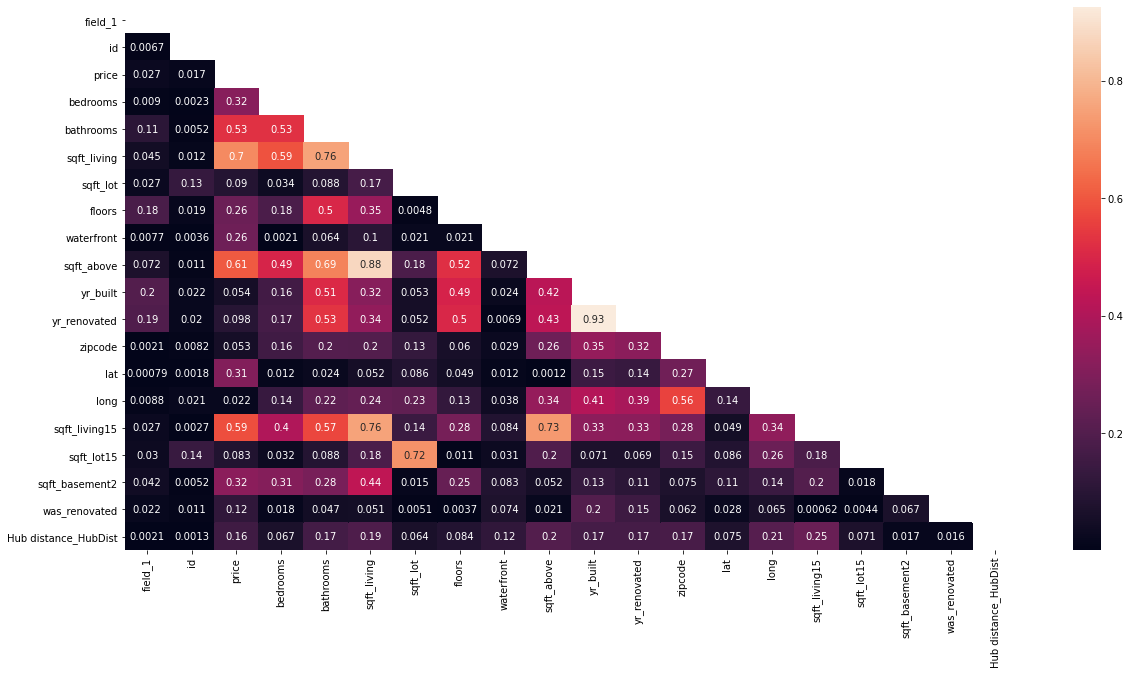

In [29]:
#checking for feature independence
mask = np.triu(np.ones_like(cleaned_housing.corr(), dtype=bool))

plt.figure(figsize=(20,10))

cor = cleaned_housing.corr().abs()
sns.heatmap(cor, mask=mask, annot=True);

In [30]:
#correlation based on our 'price' target variable
cleaned_housing.corr().price.sort_values(ascending=False)

price                   1.000000
sqft_living             0.701917
sqft_above              0.605368
sqft_living15           0.585241
bathrooms               0.525906
sqft_basement2          0.323799
bedrooms                0.315954
lat                     0.306692
waterfront              0.264306
floors                  0.256804
was_renovated           0.117543
yr_renovated            0.097541
sqft_lot                0.089876
sqft_lot15              0.082845
yr_built                0.053953
field_1                 0.027436
long                    0.022036
id                     -0.016772
zipcode                -0.053402
Hub distance_HubDist   -0.156007
Name: price, dtype: float64

In [31]:
## creating new column ratios to adjust for multicollinearity between variables
cleaned_housing['bed_bath_ratio'] = (cleaned_housing['bedrooms'] /  cleaned_housing['bathrooms'])
cleaned_housing['bath_bed_ratio'] = (cleaned_housing['bathrooms'] /  cleaned_housing['bedrooms'])
cleaned_housing['sqft_living_to_bedroom_ratio'] = (cleaned_housing['sqft_living'] /  cleaned_housing['bedrooms'])
cleaned_housing['sqft_living_to_bathroom_ratio'] = (cleaned_housing['sqft_living'] /  cleaned_housing['bathrooms'])
cleaned_housing['ratio_sqft_lot_living'] = (cleaned_housing['sqft_lot'] /  cleaned_housing['sqft_living'])
cleaned_housing['ratio_sqft_living_lot'] = (cleaned_housing['sqft_living'] /  cleaned_housing['sqft_lot'])

In [32]:
#creation of two new columns "age at sale" and "age renovation at sale"
cleaned_housing['age_at_sale'] = (cleaned_housing['date'].str[:4].astype(int) - cleaned_housing['yr_built']).astype(int)
cleaned_housing['age_renovation_at_sale'] = (cleaned_housing['date'].str[:4].astype(int) - cleaned_housing['yr_renovated']).astype(int)

In [33]:
#cleaning up column names, changing column to string and dropping columns
cleaned_housing.rename(columns = {'Hub distance_HubDist':'Distance_to_Water'}, inplace = True)
cleaned_housing['zipcode'] = cleaned_housing['zipcode'].astype(str)
cleaned_housing = cleaned_housing.drop(['date', 'field_1', 'sqft_basement'], axis=1)

# Target Exploration
Exploring the distribution of our target variable.

In [34]:
min = cleaned_housing['price'].min()
max = cleaned_housing['price'].max()
mean = cleaned_housing['price'].mean()

print (f"The sale price range of homes sold is {min} to {max}")
print (f"The mean sale price of homes was {mean}")

The sale price range of homes sold is 78000 to 7700000
The mean sale price of homes was 540296.5735055795


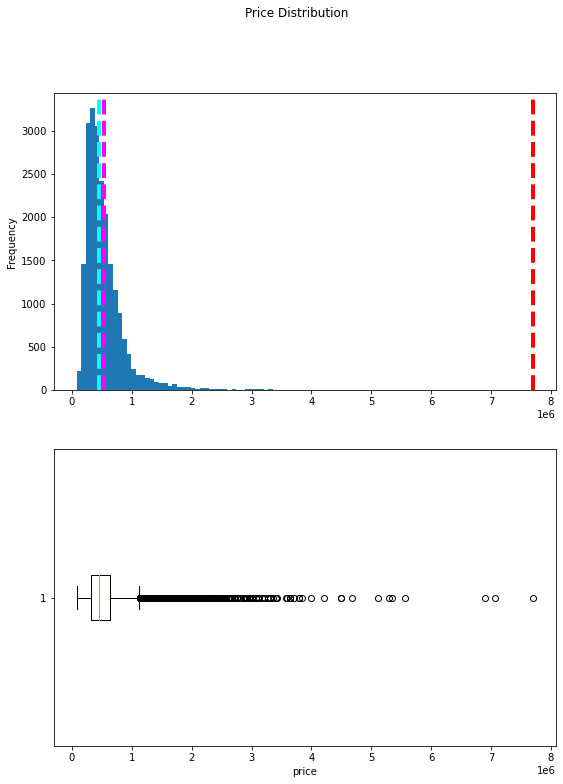

In [35]:
label = cleaned_housing['price']
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=4)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=4)
ax[0].axvline(label.max(), color='red', linestyle='dashed', linewidth=4)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('price')
fig.suptitle('Price Distribution');

In [36]:
print ('Skewness =', stats.skew(cleaned_housing['price']))
print ('Kurtosis =', stats.kurtosis(cleaned_housing['price']))

Skewness = 4.023085207745834
Kurtosis = 34.53308449607733


## Observations

- price is normally distributed but has a significant right tail skew.
- Since the peak of the distribution is to the left of our mean, price is positively skewed.    
- This means that more than half of the houses in our dataset sold for less than the average price $540,000. 
- Our kurtosis and skew are high - we expect to see a positive skew and tail.
- Looking at our box plot - this illustrates that clearly - we have a number of outliers that sold for 
  significantly more than our average.
- Moving forward, we will need to account for some of this skewdness in our models.

# Train Test Split 

In [37]:
#Setting up train test split
X = cleaned_housing.drop(['price'], axis=1)
y = cleaned_housing['price']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=57)

In [38]:
#Combining splits to get test and train complete df's for instances when we will want to use the entire dataset
train_df = pd.concat([y_train, X_train], axis=1)
test_df = pd.concat([y_test, X_test], axis=1)

In [39]:
# 15117 entries
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 20406 to 3023
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             15117 non-null  int64  
 1   bedrooms                       15117 non-null  int64  
 2   bathrooms                      15117 non-null  float64
 3   sqft_living                    15117 non-null  int64  
 4   sqft_lot                       15117 non-null  int64  
 5   floors                         15117 non-null  float64
 6   waterfront                     15117 non-null  bool   
 7   view                           15117 non-null  object 
 8   condition                      15117 non-null  object 
 9   grade                          15117 non-null  object 
 10  sqft_above                     15117 non-null  int64  
 11  yr_built                       15117 non-null  int64  
 12  yr_renovated                   15117 non-nu

In [40]:
# 6480 entries
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6480 entries, 7842 to 9367
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             6480 non-null   int64  
 1   bedrooms                       6480 non-null   int64  
 2   bathrooms                      6480 non-null   float64
 3   sqft_living                    6480 non-null   int64  
 4   sqft_lot                       6480 non-null   int64  
 5   floors                         6480 non-null   float64
 6   waterfront                     6480 non-null   bool   
 7   view                           6480 non-null   object 
 8   condition                      6480 non-null   object 
 9   grade                          6480 non-null   object 
 10  sqft_above                     6480 non-null   int64  
 11  yr_built                       6480 non-null   int64  
 12  yr_renovated                   6480 non-null 

In [41]:
y_train.mean()

540447.5557981081

## Dummy Regressor
This dummy regressor is the simplest approach to the problem. In our case the dummy regressor simply predicts the mean of the training set. Simply put, for each new home price we want to predict - the dummy regressor predicts that price as the average price of homes in our training data ($540,000). 

In [42]:
#DummyRegressor scores for train and test sets
dummy_lr = DummyRegressor()
dummy_lr.fit(X_train, y_train)

print("Dummy Regressor Model:")

print(dummy_lr.score(X_train, y_train))
print(dummy_lr.score(X_test, y_test))

Dummy Regressor Model:
0.0
-1.9627021792256727e-06


# Baseline Model (Simple Regression Models)

**Simple Model Regression**

 We have one simple model and based upon what we see we'll build some iterations upon it.

### Simple Regression Model

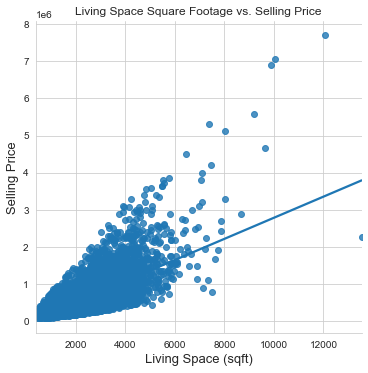

In [43]:
#our most correlated feature is sqft_living. Let's take a look at this visually.
sns.set_style('whitegrid')

sns.lmplot(x ='sqft_living', y ='price',ci=None, data = train_df).set(title='Living Space Square Footage vs. Selling Price')
plt.xlabel("Living Space (sqft)", fontsize = 13)
plt.ylabel("Selling Price", fontsize = 13);



In [44]:
#using subset of train df

simple_df = train_df.filter(['price', 'sqft_living'], axis=1)
simple_model = sm.formula.ols('price ~ sqft_living',simple_df).fit()
simple_model_summary = simple_model.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 1.486e+04
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:48:29   Log-Likelihood:            -2.1013e+05
No. Observations:               15117   AIC:                         4.203e+05
Df Residuals:                   15115   BIC:                         4.203e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.065e+04   5301.658     -9.554      0.000    -6.1e+04   -4.03e+04
sqft_living   283.8736      2.329    121.883      0.000     279.308     288.439
==============================================================================
Omnibus:                    10808.623   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           470973.629
Skew:                           2.943   Prob(JB):                         0.00
Kurtosis:                      29.704   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

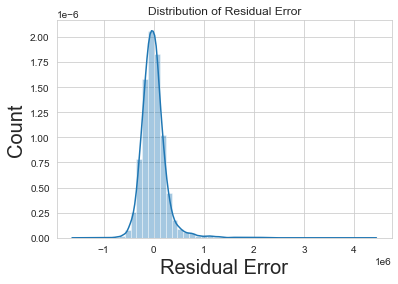

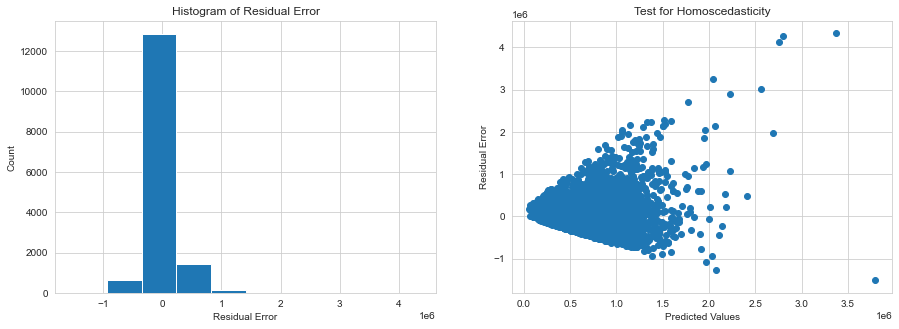

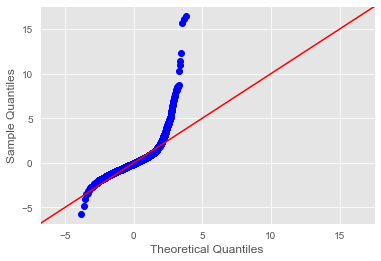

In [45]:
p = sns.distplot(simple_model.resid);
plt.xlabel("Residual Error", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
p.set_title("Distribution of Residual Error");

resid = simple_model.resid

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(resid)
ax[0].set_xlabel("Residual Error")
ax[0].set_ylabel("Count")
ax[0].set_title(label="Histogram of Residual Error");

ax[1].scatter(x=simple_model.fittedvalues,y=resid)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residual Error")
ax[1].set_title(label="Test for Homoscedasticity")

plt.style.use('ggplot')
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True);

In [46]:
print(f'R-squared training model is {round(simple_model.rsquared,2)}')
print(f'P-Value training model is {simple_model.f_pvalue}')
print(f'Price standard error training model is {round(simple_model.bse,0)[0]}')
print(f'sqft_living coef training model is {round(simple_model.params[1])}')


R-squared training model is 0.5
P-Value training model is 0.0
Price standard error training model is 5302.0
sqft_living coef training model is 284.0


### Simple Regression Model - refining 1

- our residual error shows a significant right tail skew
- also our test for Homoscedasticity failed.
- lets try and remove our heavy outliers to see if that improves our model assumptions

In [47]:
#Model 1 - Simple Regression 2
#using subset of train_df. 
#refining model by dropping price values that are +3std away from the mean.

simple_std = simple_df['price'].std()
simple_mean = simple_df['price'].mean()
simple_drop = (simple_std *3) + simple_mean
simple_drop

1652910.732318603

In [48]:
#dropping rows where homes sold for more than 3 std away from the mean
simple_df.drop(simple_df[ simple_df['price'] >= 1652910 ].index, inplace = True)

In [49]:
#14838, current rows. dropped 279.
simple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14838 entries, 20406 to 3023
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   price        14838 non-null  int64
 1   sqft_living  14838 non-null  int64
dtypes: int64(2)
memory usage: 347.8 KB


In [50]:
simple_model2 = sm.formula.ols('price ~ sqft_living',simple_df).fit()
simple_model2_summary = simple_model2.summary()
simple_model2_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.173e+04
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:48:29   Log-Likelihood:            -2.0173e+05
No. Observations:               14838   AIC:                         4.035e+05
Df Residuals:                   14836   BIC:                         4.035e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.566e+04   4205.332     20.370      0.000    7.74e+04    9.39e+04
sqft_living   207.2061      1.913    108.318      0.000     203.457     210.956
==============================================================================
Omnibus:                     2467.007   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5326.670
Skew:                           0.982   Prob(JB):                         0.00
Kurtosis:                       5.182   Cond. No.                     5.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
print(f'R-squared training model is {round(simple_model.rsquared,2)}')
print(f'P-Value training model is {simple_model.f_pvalue}')
print(f'Price standard error training model is {round(simple_model.bse,0)[0]}')
print(f'sqft_living coef training model is {round(simple_model.params[1])}')
print()
print(f'R-squared simple_model2 is {round(simple_model2.rsquared,2)}')
print(f'P-Value simple_model2 is {simple_model2.f_pvalue}')
print(f'Price standard error simple_model2 is {round(simple_model2.bse,0)[0]}')
print(f'sqft_living coef simple_model2 is {round(simple_model2.params[1])}')

R-squared training model is 0.5
P-Value training model is 0.0
Price standard error training model is 5302.0
sqft_living coef training model is 284.0

R-squared simple_model2 is 0.44
P-Value simple_model2 is 0.0
Price standard error simple_model2 is 4205.0
sqft_living coef simple_model2 is 207.0


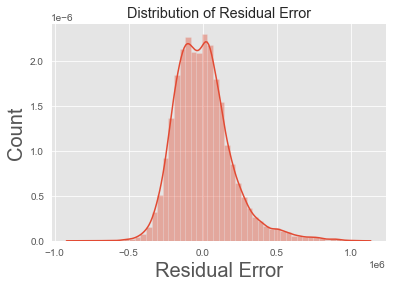

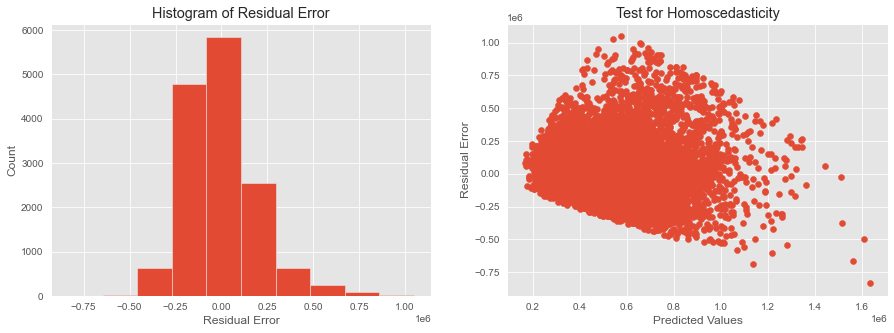

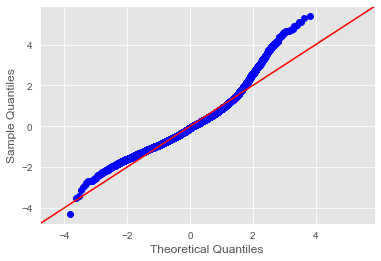

In [52]:
p = sns.distplot(simple_model2.resid);
plt.xlabel("Residual Error", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
p.set_title("Distribution of Residual Error");

resid = simple_model2.resid

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(resid)
ax[0].set_xlabel("Residual Error")
ax[0].set_ylabel("Count")
ax[0].set_title(label="Histogram of Residual Error");

ax[1].scatter(x=simple_model2.fittedvalues,y=resid)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residual Error")
ax[1].set_title(label="Test for Homoscedasticity")

plt.style.use('ggplot')
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True);

### Simple Regression Model - refining 2
- our residual error is improved
- also our test for Homoscedasticity looks better but our QQ plot still shows that heavy right tail skew
- lets try and remove take the log of our target variable to improve this

In [53]:
#taking the log of our target variable price
logprice = np.log(simple_df['price'])
simple_model3 = sm.formula.ols('logprice ~ sqft_living',simple_df).fit()
simple_model3_summary = simple_model3.summary()
simple_model3_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.080e+04
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:48:30   Log-Likelihood:                -6216.5
No. Observations:               14838   AIC:                         1.244e+04
Df Residuals:                   14836   BIC:                         1.245e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2529      0.008   1538.047      0.000      12.237      12.268
sqft_living     0.0004   3.62e-06    103.913      0.000       0.000       0.000
==============================================================================
Omnibus:                       84.734   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.767
Skew:                          -0.026   Prob(JB):                     6.38e-14
Kurtosis:                       2.691   Cond. No.                     5.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
print(f'R-squared training model is {round(simple_model.rsquared,2)}')
print(f'P-Value training model is {simple_model.f_pvalue}')
print(f'Price standard error training model is {round(simple_model.bse,0)[0]}')
print(f'sqft_living coef training model is {round(simple_model.params[1])}')
print()
print(f'R-squared simple_model2 is {round(simple_model2.rsquared,2)}')
print(f'P-Value simple_model2 is {simple_model2.f_pvalue}')
print(f'Price standard error simple_model2 is {round(simple_model2.bse,0)[0]}')
print(f'sqft_living coef simple_model2 is {round(simple_model2.params[1])}')
print()
print(f'R-squared simple_model3 is {round(simple_model3.rsquared,2)}')
print(f'P-Value simple_model3 is {simple_model3.f_pvalue}')
print(f'Price standard error simple_model3 is {round(simple_model3.bse,0)[0]}')
print(f'sqft_living coef simple_model3 is {round(simple_model3.params[1])}')

R-squared training model is 0.5
P-Value training model is 0.0
Price standard error training model is 5302.0
sqft_living coef training model is 284.0

R-squared simple_model2 is 0.44
P-Value simple_model2 is 0.0
Price standard error simple_model2 is 4205.0
sqft_living coef simple_model2 is 207.0

R-squared simple_model3 is 0.42
P-Value simple_model3 is 0.0
Price standard error simple_model3 is 0.0
sqft_living coef simple_model3 is 0.0


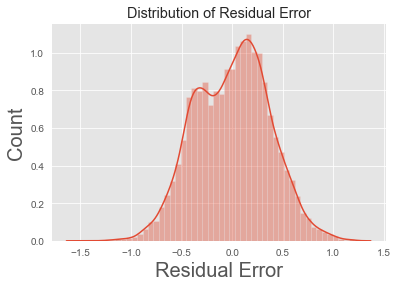

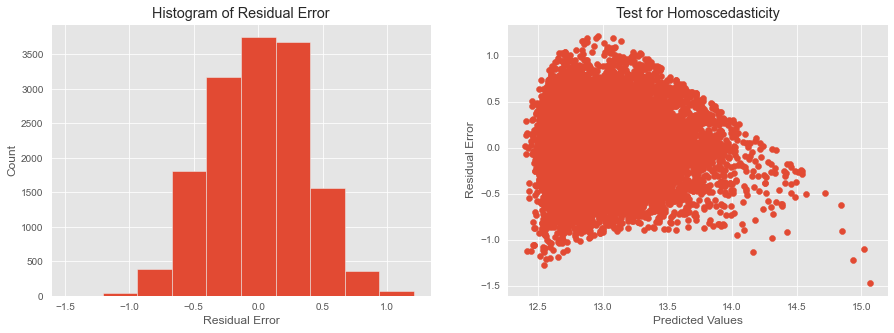

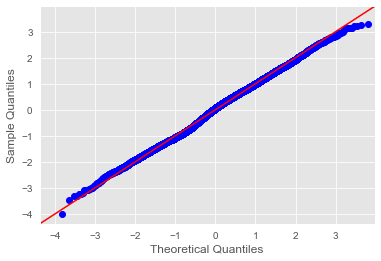

In [55]:
p = sns.distplot(simple_model3.resid);
plt.xlabel("Residual Error", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
p.set_title("Distribution of Residual Error");

resid = simple_model3.resid

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(resid)
ax[0].set_xlabel("Residual Error")
ax[0].set_ylabel("Count")
ax[0].set_title(label="Histogram of Residual Error");

ax[1].scatter(x=simple_model3.fittedvalues,y=resid)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residual Error")
ax[1].set_title(label="Test for Homoscedasticity")

plt.style.use('ggplot')
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True);

## Observations
- Our intial model gives the following formula : y = 284 * ('sqft_living') - 50,650.
- Sqft_living accounts for about 50% on average of the variance in our sale price.
- Each unit increase of Sqft_living increases the selling price of homes by on average about $284.
- We noticed that our model was not meeting the Homoskedasticity or normal error distribution assumptions so we tried   a few iterations to account for this.
- Model assumptions:
    1. linearity between feature and target variable - illustrated by positive correlation of 0.702
    2. low multicolinearity between target and feature variable - the lowest condition number we achieved was 5,630 - 
        so this assumption wasnt met.
    3. normally distributed errors with a mean of 0. 
       the QQ plot and histogram from model 1 show a significant right tail skew. The plots from iterations 2 and 3
       show a normal distribution. 
    4. Homoskedasticity - variance is constant. Assumption was met in our model iterations 2 and 3.
    5. Errors are not correlated.
    
- Our R2 actually decreased with each successive iteration. When comparing this base model to our multiple regression 
  models we'll use the average R2 of 0.45.   
- We also decided to keep these changes because our model assumptions are met in the last iteration.

# Multiple Regression Models

For our first multiple regression model, we'll create a model with all our numeric columns.

In [56]:
#recalling our X_train and y_train df's from our previous split
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 20406 to 3023
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             15117 non-null  int64  
 1   bedrooms                       15117 non-null  int64  
 2   bathrooms                      15117 non-null  float64
 3   sqft_living                    15117 non-null  int64  
 4   sqft_lot                       15117 non-null  int64  
 5   floors                         15117 non-null  float64
 6   waterfront                     15117 non-null  bool   
 7   view                           15117 non-null  object 
 8   condition                      15117 non-null  object 
 9   grade                          15117 non-null  object 
 10  sqft_above                     15117 non-null  int64  
 11  yr_built                       15117 non-null  int64  
 12  yr_renovated                   15117 non-nu

In [57]:
#creating new numeric df from our train split
X_train_numeric =X_train.filter(['bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                                    'sqft_above','yr_built','yr_renovated','lat','long','sqft_living15',
                                    'sqft_lot15','sqft_basement2','Distance_to_Water' ], axis=1)
X_train_numeric.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 20406 to 3023
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           15117 non-null  int64  
 1   bathrooms          15117 non-null  float64
 2   sqft_living        15117 non-null  int64  
 3   sqft_lot           15117 non-null  int64  
 4   floors             15117 non-null  float64
 5   sqft_above         15117 non-null  int64  
 6   yr_built           15117 non-null  int64  
 7   yr_renovated       15117 non-null  int64  
 8   lat                15117 non-null  float64
 9   long               15117 non-null  float64
 10  sqft_living15      15117 non-null  int64  
 11  sqft_lot15         15117 non-null  int64  
 12  sqft_basement2     15117 non-null  int64  
 13  Distance_to_Water  15117 non-null  float64
dtypes: float64(5), int64(9)
memory usage: 1.7 MB


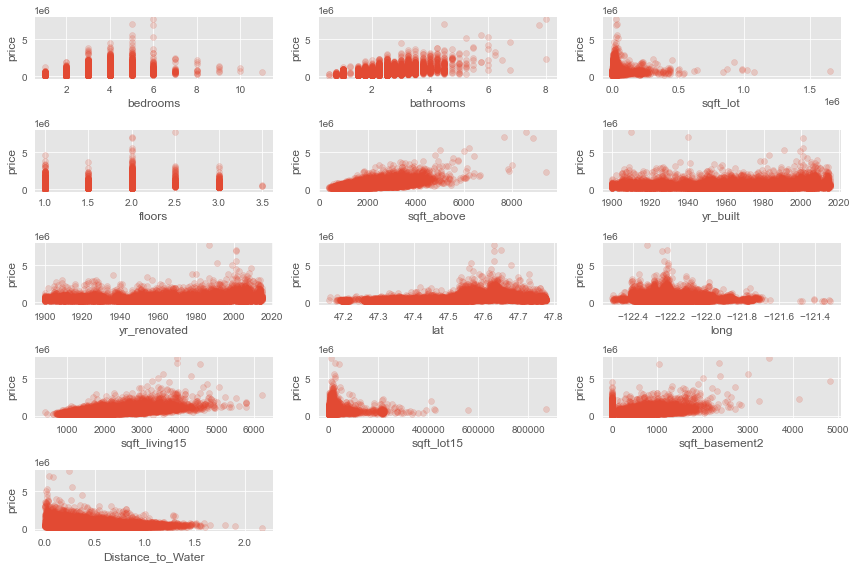

In [58]:
#evaluating numeric features
scatterplot_data = X_train_numeric.drop("sqft_living", axis=1) #already graphed above

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(12, 8))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train_numeric[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

    
fig.delaxes(axes[4][1])
fig.delaxes(axes[4][2])

### Muliple Regression Model 1
- Model created with all our numeric columns from our original X_train dataset.

In [59]:
#model with all our numeric features
multi_model = LinearRegression()
##performing 3 separate train/tets splits on our X_train, y_train
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
#performing regression on all columns in our dataset
multi_model_scores = cross_validate(
    estimator=multi_model,
    X=X_train_numeric,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", multi_model_scores["train_score"].mean())
print("Validation score:", multi_model_scores["test_score"].mean())



Current Model
Train score:      0.6334429950650039
Validation score: 0.6099003027567962


**Observations**
- with an r2 of 0.61 ( validation score) is higher than the 0.45 mean r2 from our 3 simple models iterations, 
- we need to see more information about our multicollinearity, pvalues, and coeficients. Lets run the regression 
  with the statsmodel method to ensure we can check the condition number


In [60]:
sm.OLS(y_train, sm.add_constant(X_train_numeric)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1967.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:48:31   Log-Likelihood:            -2.0781e+05
No. Observations:               15117   AIC:                         4.157e+05
Df Residuals:                   15103   BIC:                         4.158e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5.646e+07   2.09e+06    -27.053      0.000   -6.06e+07   -5.24e+07
bedrooms          -6.137e+04   2587.515    -23.719      0.000   -6.64e+04   -5.63e+04
bathrooms          6.734e+04   4407.207     15.280      0.000    5.87e+04     7.6e+04
sqft_living         162.5246      2.892     56.197      0.000     156.856     168.193
sqft_lot              0.2131      0.063      3.385      0.001       0.090       0.336
floors             1.331e+04   4775.682      2.787      0.005    3950.231    2.27e+04
sqft_above          100.3035      2.862     35.047      0.000      94.694     105.913
yr_built          -3573.0929    173.435    -20.602      0.000   -3913.046   -3233.140
yr_renovated       1211.7139    177.145      6.840      0.000     864.488    1558.940
lat                5.966e+05   1.38e+04     43.128      0.000     5.7e+05    6.24e+05
long              -2.672e+05   1.58e+04    -16.886      0.000   -2.98e+05   -2.36e+05
sqft_living15        79.0523      4.423     17.875      0.000      70.383      87.721
sqft_lot15           -0.4657      0.100     -4.647      0.000      -0.662      -0.269
sqft_basement2       62.2220      3.496     17.798      0.000      55.369      69.075
Distance_to_Water  -6.63e+04   7009.058     -9.460      0.000      -8e+04   -5.26e+04
==============================================================================
Omnibus:                    12559.338   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           942202.787
Skew:                           3.529   Prob(JB):                         0.00
Kurtosis:                      41.027   Cond. No.                     2.02e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.63e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Observations**

- several things are of note - our condition number is really high indicating an issue with multicollinearity
  which is expected - considering we threw everything at this model. We know that there is some multicollinearity
  between some of our sqft variable.
- Interestingly, all our variables are statistically significant at an alpha=.05 level.
- our coefficients are all very different, which makes interpretating this model difficult.
- Lets try removing some variables and scaling our data so we can have our coefficients in the same scale.
- To do this we'll use the recursive feature module from sklearn

In [61]:
#using RFE modedule to select for the top 4 features
#scaling our X_train_numeric dataset
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select =4)

ss = StandardScaler()
ss.fit(X_train_numeric)
X_train_numeric_scaled = ss.transform(X_train_numeric)
select.fit(X= X_train_numeric_scaled, y=y_train)
select.support_

array([False, False,  True, False, False,  True, False, False,  True,
       False, False, False,  True, False])

**Observations**
- With Recursive Feature Elimination - we're selecting the top 4 features to include in our model
   these are:
   1. sqft_living
   2. sqft_above 
   3. latitude  
   4. sqft_basement
- we've also scaled our features so our coefficients should be more interpretable. 
- Lets run another regression model with these four features included.

### Muliple Regression Model 1b

In [62]:
#creating new df with only the relevant 4 columns
X_train_numeric2 = X_train_numeric.filter(['sqft_living','sqft_above','lat','sqft_basement2'], axis=1)

multi_model_b = LinearRegression()
##performing 3 separate train/tets splits on our X_train, y_train
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
#performing regression on all columns in our dataset
multi_model_b_scores = cross_validate(
    estimator=multi_model_b,
    X=X_train_numeric2,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", multi_model_b_scores["train_score"].mean())
print("Validation score:", multi_model_b_scores["test_score"].mean())
print()
print("Previous Model")
print("Train score:     ", multi_model_scores["train_score"].mean())
print("Validation score:", multi_model_scores["test_score"].mean())

Current Model
Train score:      0.57246679345766
Validation score: 0.5528461425859618

Previous Model
Train score:      0.6334429950650039
Validation score: 0.6099003027567962


In [63]:
##lets scale our entire X_train_numeric2 dataframe
ss = StandardScaler()
ss.fit(X_train_numeric2)
X_train_numeric2_scaled = ss.transform(X_train_numeric2)

In [64]:
##using OLS to investigate unexpected result
sm.OLS(y_train, sm.add_constant(X_train_numeric2_scaled)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     6637.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:48:32   Log-Likelihood:            -2.0895e+05
No. Observations:               15117   AIC:                         4.179e+05
Df Residuals:                   15113   BIC:                         4.179e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.404e+05   1981.417    272.758      0.000    5.37e+05    5.44e+05
x1          1.304e+05   1013.287    128.702      0.000    1.28e+05    1.32e+05
x2          1.136e+05   1252.158     90.729      0.000    1.11e+05    1.16e+05
x3          1.004e+05   1992.771     50.383      0.000    9.65e+04    1.04e+05
x4          5.844e+04   1795.691     32.545      0.000    5.49e+04     6.2e+04
==============================================================================
Omnibus:                    12580.733   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           846029.369
Skew:                           3.580   Prob(JB):                         0.00
Kurtosis:                      38.943   Cond. No.                     1.62e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.13e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Observations**
- Taking a look at the condition number - it is extremely high, indicating we are violating our multicollinearity   assumption
- This is expected because the 3 sqft features (sqft_living, sqft_above, sqft_basement) we included have correlation between them. (sqft_living is the sum of sqft_above and sqft_basement)
    
- we've also scaled our features so our coefficients are more interpretable. 
- Lets try adding in some of our categorical (non-numerical) features and rerun the model.

### Feature Engineering for Muliple Regression Model 2 

- lets encode our categorical values - waterfront, zipcode, was_renovated, and condition. 
- we'll use the OrdinalEncoder for waterfront and was_renovated - since they have Boolean values. 
- for zipcode and condition we'll create dummy variables using get_dummies from pandas.
- lets also include some columns we created earlier - the ratio and age features.

In [65]:
##getting values for waterfront features
X_train['waterfront'].value_counts()

False    15008
True       109
Name: waterfront, dtype: int64

In [66]:
#take boolean column of 'waterfront' and encode
waterfront_train = X_train[["waterfront"]]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]

array([False,  True])

In [67]:
#flattening
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()
waterfront_encoded_train

array([0., 0., 0., ..., 0., 0., 0.])

In [68]:
#replacing values and checking
X_train["waterfront"] = waterfront_encoded_train
X_train.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,was_renovated,Distance_to_Water,bed_bath_ratio,bath_bed_ratio,sqft_living_to_bedroom_ratio,sqft_living_to_bathroom_ratio,ratio_sqft_lot_living,ratio_sqft_living_lot,age_at_sale,age_renovation_at_sale
20406,6788200596,4,3.5,3440,3800,3.0,0.0,NONE,Average,9 Better,...,False,0.184728,1.142857,0.875,860.0,982.857143,1.104651,0.905263,0,0
13931,3223059141,2,1.0,1420,81892,1.0,0.0,NONE,Average,7 Average,...,False,0.403674,2.000000,0.500,710.0,1420.000000,57.670423,0.017340,58,58
4361,2767705010,4,2.0,1940,5000,1.0,0.0,NONE,Good,7 Average,...,False,0.795404,2.000000,0.500,485.0,970.000000,2.577320,0.388000,104,104
1505,2214800270,4,2.5,2770,7000,1.0,0.0,NONE,Good,7 Average,...,False,0.761639,1.600000,0.625,692.5,1108.000000,2.527076,0.395714,35,35
7978,510001280,4,2.0,2190,4560,2.5,0.0,NONE,Very Good,8 Good,...,False,0.615517,2.000000,0.500,547.5,1095.000000,2.082192,0.480263,104,104


In [69]:
#checking newly created values for waterfront feature
X_train['waterfront'].value_counts()

0.0    15008
1.0      109
Name: waterfront, dtype: int64

In [70]:
##getting values for was_renovated feature
X_train['was_renovated'].value_counts()

False    14609
True       508
Name: was_renovated, dtype: int64

In [71]:
#take boolean column of 'was_renovated', encoding, and flattening
was_renovated_train = X_train[["was_renovated"]]
encoder_was_renovated = OrdinalEncoder()
encoder_was_renovated.fit(was_renovated_train)
was_renovated_encoded_train = encoder_was_renovated.transform(was_renovated_train)
was_renovated_encoded_train = was_renovated_encoded_train.flatten()
was_renovated_encoded_train
#replacing in X_train
X_train["was_renovated"] = was_renovated_encoded_train
X_train.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,was_renovated,Distance_to_Water,bed_bath_ratio,bath_bed_ratio,sqft_living_to_bedroom_ratio,sqft_living_to_bathroom_ratio,ratio_sqft_lot_living,ratio_sqft_living_lot,age_at_sale,age_renovation_at_sale
20406,6788200596,4,3.5,3440,3800,3.0,0.0,NONE,Average,9 Better,...,0.0,0.184728,1.142857,0.875,860.0,982.857143,1.104651,0.905263,0,0
13931,3223059141,2,1.0,1420,81892,1.0,0.0,NONE,Average,7 Average,...,0.0,0.403674,2.000000,0.500,710.0,1420.000000,57.670423,0.017340,58,58
4361,2767705010,4,2.0,1940,5000,1.0,0.0,NONE,Good,7 Average,...,0.0,0.795404,2.000000,0.500,485.0,970.000000,2.577320,0.388000,104,104
1505,2214800270,4,2.5,2770,7000,1.0,0.0,NONE,Good,7 Average,...,0.0,0.761639,1.600000,0.625,692.5,1108.000000,2.527076,0.395714,35,35
7978,510001280,4,2.0,2190,4560,2.5,0.0,NONE,Very Good,8 Good,...,0.0,0.615517,2.000000,0.500,547.5,1095.000000,2.082192,0.480263,104,104


In [72]:
#checking newly created values for was_renovated feature
X_train['was_renovated'].value_counts()

0.0    14609
1.0      508
Name: was_renovated, dtype: int64

In [73]:
#getting values for zipcode feature
X_train['zipcode'].value_counts()

98038    430
98103    425
98115    424
98052    407
98034    385
        ... 
98109     74
98010     63
98024     57
98148     42
98039     39
Name: zipcode, Length: 70, dtype: int64

In [74]:
##getting values for condition feature
X_train['condition'].value_counts()

Average      9794
Good         3971
Very Good    1217
Fair          118
Poor           17
Name: condition, dtype: int64

In [75]:
#lets drop all columns we're not using,
X_train.drop(X_train.columns[[5, 7, 9,14, 15, 16, 17]], axis = 1, inplace = True)
#sanity check
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 20406 to 3023
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             15117 non-null  int64  
 1   bedrooms                       15117 non-null  int64  
 2   bathrooms                      15117 non-null  float64
 3   sqft_living                    15117 non-null  int64  
 4   sqft_lot                       15117 non-null  int64  
 5   waterfront                     15117 non-null  float64
 6   condition                      15117 non-null  object 
 7   sqft_above                     15117 non-null  int64  
 8   yr_built                       15117 non-null  int64  
 9   yr_renovated                   15117 non-null  int64  
 10  zipcode                        15117 non-null  object 
 11  sqft_basement2                 15117 non-null  int64  
 12  was_renovated                  15117 non-nu

In [76]:
#create dummy variables for the "condition" and "zipcode" columns
condition_dummies = pd.get_dummies(X_train['condition'], drop_first=True)
zipcode_dummies = pd.get_dummies(X_train['zipcode'], drop_first=True)

In [77]:
#merging condition and zipcode dummy datasets to X_train
X_train = pd.concat([X_train, condition_dummies, zipcode_dummies], axis=1)
X_train.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,sqft_above,yr_built,yr_renovated,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
20406,6788200596,4,3.5,3440,3800,0.0,Average,3440,2014,2014,...,0,0,0,0,0,0,0,0,0,0
13931,3223059141,2,1.0,1420,81892,0.0,Average,1180,1956,1956,...,0,0,0,0,0,0,0,0,0,0
4361,2767705010,4,2.0,1940,5000,0.0,Good,980,1910,1910,...,0,0,0,0,0,0,0,0,0,0
1505,2214800270,4,2.5,2770,7000,0.0,Good,1940,1979,1979,...,0,0,0,0,0,0,0,0,0,0
7978,510001280,4,2.0,2190,4560,0.0,Very Good,2190,1910,1910,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#dropping condition and zipcode original columns
X_train.drop(['condition', 'zipcode'], axis = 1, inplace = True)

In [79]:
X_train.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
       'sqft_above', 'yr_built', 'yr_renovated', 'sqft_basement2',
       'was_renovated', 'Distance_to_Water', 'bed_bath_ratio',
       'bath_bed_ratio', 'sqft_living_to_bedroom_ratio',
       'sqft_living_to_bathroom_ratio', 'ratio_sqft_lot_living',
       'ratio_sqft_living_lot', 'age_at_sale', 'age_renovation_at_sale',
       'Fair', 'Good', 'Poor', 'Very Good', '98002', '98003', '98004', '98005',
       '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
       '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
       '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98052',
       '98053', '98055', '98056', '98058', '98059', '98065', '98070', '98072',
       '98074', '98075', '98077', '98092', '98102', '98103', '98105', '98106',
       '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118',
       '98119', '98122', '98125', '98126',

### Multiple Regression Model 1c
- Now that we've encoded our condition, zipcode, renovation, and waterfront features. Lets throw everything all our     features and analyze our results 
- Lets also scale our X_train to be able to interpret our coefficents with a little more ease
- Still using cross validate to split our training set into three.

In [80]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)

In [81]:
multi_model_c = LinearRegression()
##performing 3 separate train/tets splits on our X_train, y_train
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
#performing regression on all columns in our dataset
multi_model_c_scores = cross_validate(
    estimator=multi_model_c,
    X=X_train_scaled,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", multi_model_c_scores["train_score"].mean())
print("Validation score:", multi_model_c_scores["test_score"].mean())
print()
print("Model 1")
print("Train score:     ", multi_model_scores["train_score"].mean())
print("Validation score:", multi_model_scores["test_score"].mean())
print()
print("Model 1B")
print("Train score:     ", multi_model_b_scores["train_score"].mean())
print("Validation score:", multi_model_b_scores["test_score"].mean())

Current Model
Train score:      0.8140312189715558
Validation score: 0.790276473842936

Model 1
Train score:      0.6334429950650039
Validation score: 0.6099003027567962

Model 1B
Train score:      0.57246679345766
Validation score: 0.5528461425859618


In [82]:
#Huge jump in our validation score. Let's checkout multicollinearity 
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     703.7
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:48:33   Log-Likelihood:            -2.0275e+05
No. Observations:               15117   AIC:                         4.057e+05
Df Residuals:                   15025   BIC:                         4.064e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -6.422e+07    5.7e+06    -11.260      0.000   -7.54e+07    -5.3e+07
id                             8.045e-08    4.8e-07      0.168      0.867    -8.6e-07    1.02e-06
bedrooms                      -1.442e+05   4690.885    -30.733      0.000   -1.53e+05   -1.35e+05
bathrooms                      4.132e+04   9795.411      4.218      0.000    2.21e+04    6.05e+04
sqft_living                     264.9261      5.813     45.577      0.000     253.533     276.320
sqft_lot                         -0.5612      0.072     -7.763      0.000      -0.703      -0.419
waterfront                     8.102e+05   1.63e+04     49.731      0.000    7.78e+05    8.42e+05
sqft_above                      159.7513      3.241     49.290      0.000     153.398     166.104
yr_built                       1.523e+04   1423.721     10.701      0.000    1.24e+04     1.8e+04
yr_renovated                   1.668e+04   1423.857     11.718      0.000    1.39e+04    1.95e+04
sqft_basement2                  104.8323      3.643     28.773      0.000      97.691     111.974
was_renovated                 -1.211e+04   1.83e+04     -0.661      0.509    -4.8e+04    2.38e+04
Distance_to_Water             -7.185e+04   5543.173    -12.962      0.000   -8.27e+04    -6.1e+04
bed_bath_ratio                 1.715e+05   5919.594     28.974      0.000     1.6e+05    1.83e+05
bath_bed_ratio                -1.452e+05   2.89e+04     -5.025      0.000   -2.02e+05   -8.85e+04
sqft_living_to_bedroom_ratio     18.4770     33.375      0.554      0.580     -46.941      83.895
sqft_living_to_bathroom_ratio  -392.5034     16.033    -24.481      0.000    -423.930    -361.076
ratio_sqft_lot_living          1567.5815    140.124     11.187      0.000    1292.921    1842.241
ratio_sqft_living_lot         -9.298e+04   7490.904    -12.413      0.000   -1.08e+05   -7.83e+04
age_at_sale                    1.661e+04   1422.677     11.678      0.000    1.38e+04    1.94e+04
age_renovation_at_sale         1.516e+04   1422.700     10.659      0.000    1.24e+04     1.8e+04
Fair                          -2.337e+04   1.52e+04     -1.536      0.125   -5.32e+04    6452.284
Good                           2.737e+04   3447.989      7.938      0.000    2.06e+04    3.41e+04
Poor                          -9.957e+04   3.96e+04     -2.512      0.012   -1.77e+05   -2.19e+04
Very Good                      6.669e+04   5432.672     12.276      0.000     5.6e+04    7.73e+04
98002                          1.801e+04    1.7e+04      1.057      0.291   -1.54e+04    5.14e+04
98003                           751.8354    1.5e+04      0.050      0.960   -2.86e+04    3.01e+04
98004                          7.913e+05   1.52e+04     51.985      0.000    7.61e+05    8.21e+05
98005                          3.443e+05   1.

## Observations
- as expected we have an incredible high condition number indicating several of the features in this model
  are related.  
- let's use RFECV - this will tell us what features are most important to the model without us defining a specific       number of features we want to use. 
- lets also use RFE to get an idea of the top 8 features affecting this model.

In [83]:
#identifying what features are important to the model.
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

model_for_RFECV = LinearRegression()

selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

print("Was the column selected?")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
id: False
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
waterfront: True
sqft_above: True
yr_built: True
yr_renovated: True
sqft_basement2: True
was_renovated: True
Distance_to_Water: True
bed_bath_ratio: True
bath_bed_ratio: True
sqft_living_to_bedroom_ratio: True
sqft_living_to_bathroom_ratio: True
ratio_sqft_lot_living: True
ratio_sqft_living_lot: True
age_at_sale: True
age_renovation_at_sale: True
Fair: False
Good: True
Poor: True
Very Good: True
98002: False
98003: False
98004: True
98005: True
98006: True
98007: True
98008: True
98010: True
98011: True
98014: True
98019: True
98022: False
98023: True
98024: True
98027: True
98028: True
98029: True
98030: False
98031: False
98032: False
98033: True
98034: True
98038: True
98039: True
98040: True
98042: True
98045: True
98052: True
98053: True
98055: True
98056: True
98058: True
98059: True
98065: True
98070: False
98072: True
98074: True
98075: True
98077: True
98092: True
98102: True
981

In [84]:
#identifying the top 8
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select =8)

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
select.fit(X= X_train_scaled, y=y_train)
select.support_

array([False,  True, False,  True, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [85]:
#subsetting dataset excluding zipcodes
X_train_heatmap = X_train.filter(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'sqft_above', 'yr_built',
                          'yr_renovated', 'sqft_basement2', 'was_renovated', 'Distance_to_Water', 'bed_bath_ratio',
                          'bath_bed_ratio', 'sqft_living_to_bedroom_ratio', 'sqft_living_to_bathroom_ratio', 
                          'ratio_sqft_lot_living', 'ratio_sqft_living_lot', 'age_at_sale', 'age_renovation_at_sale',
                          'Fair', 'Good', 'Poor', 'Very Good'], axis=1)

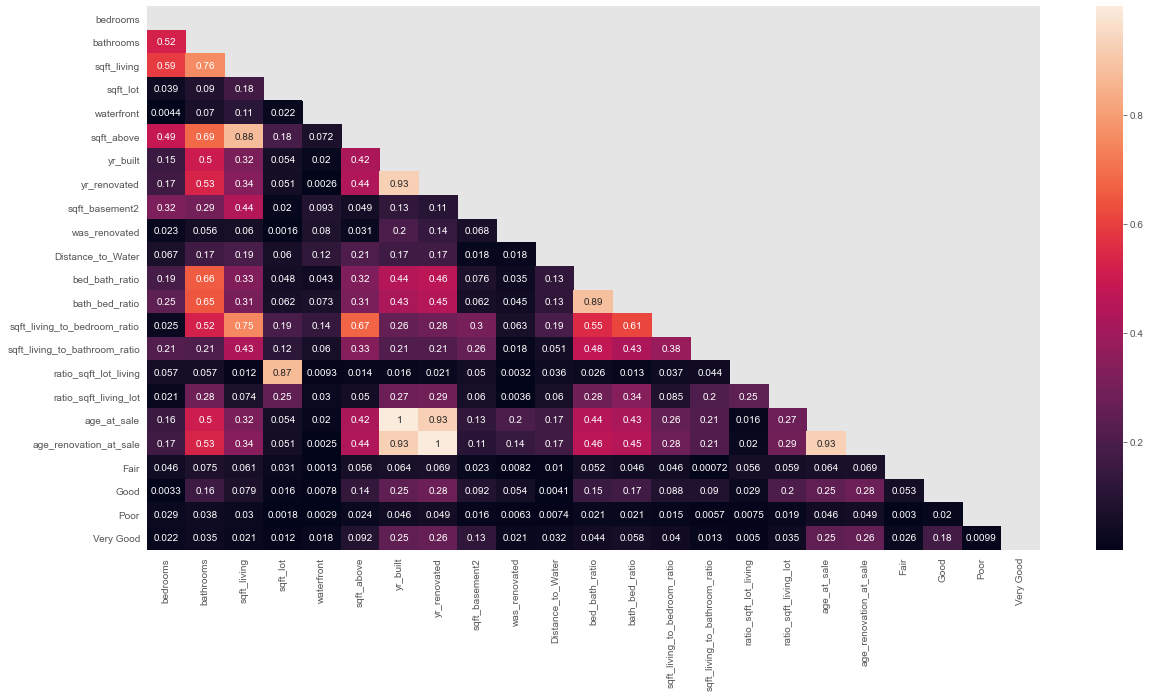

In [86]:
#visualizing correlations in our dataset excluding zipcodes

mask = np.triu(np.ones_like(X_train_heatmap.corr(), dtype=bool))

plt.figure(figsize=(20,10))

cor = X_train_heatmap.corr().abs()
sns.heatmap(cor, mask=mask, annot=True);

## Observations
- Using both the RFE and RFECV tell us something different. The RFE method says that the top 8 most significant         features are 
    1. age renovation at sale 
    2. sqft living space 
    3. age at sale
    4. year built 
    5. year renovated
    6. sq above
    7. sqft basement
    8. bedrooms
- now we know that the square footage features have multicollinearity among them as seen from the heatmap above, but sqft_living space is the feature that is most correlated with price. So we'll use that in our final model.
- we also can see that waterfront and the zip code feature are very relevant and have no meaningful correlation with other features so let's include them as well. 
- finally we know that bedrooms are given as a top feature - but since we can see that it is correlated with bathrooms and sqft_living lets use one of our bedroom ratios to eliminate multicollinearity and still include the feature in our model.


In [87]:
X_train.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
       'sqft_above', 'yr_built', 'yr_renovated', 'sqft_basement2',
       'was_renovated', 'Distance_to_Water', 'bed_bath_ratio',
       'bath_bed_ratio', 'sqft_living_to_bedroom_ratio',
       'sqft_living_to_bathroom_ratio', 'ratio_sqft_lot_living',
       'ratio_sqft_living_lot', 'age_at_sale', 'age_renovation_at_sale',
       'Fair', 'Good', 'Poor', 'Very Good', '98002', '98003', '98004', '98005',
       '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
       '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
       '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98052',
       '98053', '98055', '98056', '98058', '98059', '98065', '98070', '98072',
       '98074', '98075', '98077', '98092', '98102', '98103', '98105', '98106',
       '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118',
       '98119', '98122', '98125', '98126',

In [88]:
X_train_final = X_train.filter(['sqft_living', 'waterfront','bedrooms', 'was_renovated', 'bed_bath_ratio',
                                'ratio_sqft_living_lot','sqft_living_to_bathroom_ratio', 'Fair', 'Good', 'Poor',
                                'Very Good', '98002', '98003', '98004', '98005',
                           '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
                           '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
                           '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98052',
                            '98053', '98055', '98056', '98058', '98059', '98065', '98070', '98072',
                           '98074', '98075', '98077', '98092', '98102', '98103', '98105', '98106',
                           '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118',
                           '98119', '98122', '98125', '98126', '98133', '98136', '98144', '98146',
                           '98148', '98155', '98166', '98168', '98177', '98178', '98188', '98198', '98199' ], axis=1)

In [89]:
multi_model_3 = LinearRegression()

final_model = LinearRegression()
##performing 3 separate train/tets splits on our X_train, y_train
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
#performing regression on all columns in our dataset
final_model_scores = cross_validate(
    estimator=final_model,
    X=X_train_final,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Final Model")
print("Train score:     ", final_model_scores["train_score"].mean())
print("Validation score:", final_model_scores["test_score"].mean())
print()
print("Model 1C")
print("Train score:     ", multi_model_c_scores["train_score"].mean())
print("Validation score:", multi_model_c_scores["test_score"].mean())
print()
print("Model 1B")
print("Train score:     ", multi_model_b_scores["train_score"].mean())
print("Validation score:", multi_model_b_scores["test_score"].mean())
print()
print("Model 1")
print("Train score:     ", multi_model_scores["train_score"].mean())
print("Validation score:", multi_model_scores["test_score"].mean())

Final Model
Train score:      0.8052720552099978
Validation score: 0.7808099264106492

Model 1C
Train score:      0.8140312189715558
Validation score: 0.790276473842936

Model 1B
Train score:      0.57246679345766
Validation score: 0.5528461425859618

Model 1
Train score:      0.6334429950650039
Validation score: 0.6099003027567962


In [90]:
#lets take a look at multicollinearity using OLS
final_model = sm.OLS(y_train, sm.add_constant(X_train_final)).fit()
sm.OLS(y_train, sm.add_constant(X_train_final)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     755.1
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:49:07   Log-Likelihood:            -2.0311e+05
No. Observations:               15117   AIC:                         4.064e+05
Df Residuals:                   15036   BIC:                         4.070e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1629.3837   1.25e+04     -0.130      0.896   -2.62e+04    2.29e+04
sqft_living                     424.6403      4.413     96.233      0.000     415.991     433.290
waterfront                     8.155e+05   1.65e+04     49.398      0.000    7.83e+05    8.48e+05
bedrooms                      -1.301e+05   3058.504    -42.527      0.000   -1.36e+05   -1.24e+05
was_renovated                  6.581e+04   7662.468      8.589      0.000    5.08e+04    8.08e+04
bed_bath_ratio                 1.841e+05   5264.176     34.978      0.000    1.74e+05    1.94e+05
ratio_sqft_living_lot         -9.488e+04   6468.721    -14.667      0.000   -1.08e+05   -8.22e+04
sqft_living_to_bathroom_ratio  -414.9530     10.611    -39.105      0.000    -435.752    -394.154
Fair                          -1.995e+04   1.55e+04     -1.286      0.199   -5.04e+04    1.05e+04
Good                           1.765e+04   3352.685      5.264      0.000    1.11e+04    2.42e+04
Poor                          -9.466e+04   4.05e+04     -2.335      0.020   -1.74e+05   -1.52e+04
Very Good                      5.106e+04   5225.833      9.770      0.000    4.08e+04    6.13e+04
98002                          4573.0334   1.74e+04      0.263      0.792   -2.95e+04    3.86e+04
98003                         -3710.6419   1.53e+04     -0.242      0.808   -3.37e+04    2.63e+04
98004                          7.871e+05   1.55e+04     50.653      0.000    7.57e+05    8.18e+05
98005                          3.387e+05   1.86e+04     18.243      0.000    3.02e+05    3.75e+05
98006                          3.127e+05   1.38e+04     22.706      0.000    2.86e+05     3.4e+05
98007                          2.728e+05   1.97e+04     13.833      0.000    2.34e+05    3.11e+05
98008                          2.791e+05   1.57e+04     17.720      0.000    2.48e+05     3.1e+05
98010                          6.174e+04   2.34e+04      2.639      0.008    1.59e+04    1.08e+05
98011                          1.453e+05   1.83e+04      7.960      0.000     1.1e+05    1.81e+05
98014                          8.262e+04   2.03e+04      4.062      0.000    4.28e+04    1.22e+05
98019                          7.611e+04   1.81e+04      4.210      0.000    4.07e+04    1.12e+05
98022                          1.501e+04   1.66e+04      0.906      0.365   -1.75e+04    4.75e+04
98023                         -2.471e+04   1.37e+04     -1.810      0.070   -5.15e+04    2050.888
98024                          1.313e+05   2.44e+04      5.382      0.000    8.35e+04    1.79e+05
98027                           1.85e+05   1.44e+04     12.878      0.000    1.57e+05    2.13e+05
98028                          1.272e+05   1.59e+04      7.998      0.000     9.6e+04    1.58e+05
98029                          2.553e+05    1

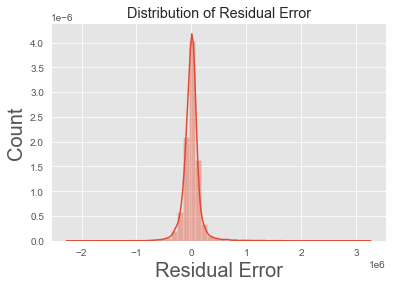

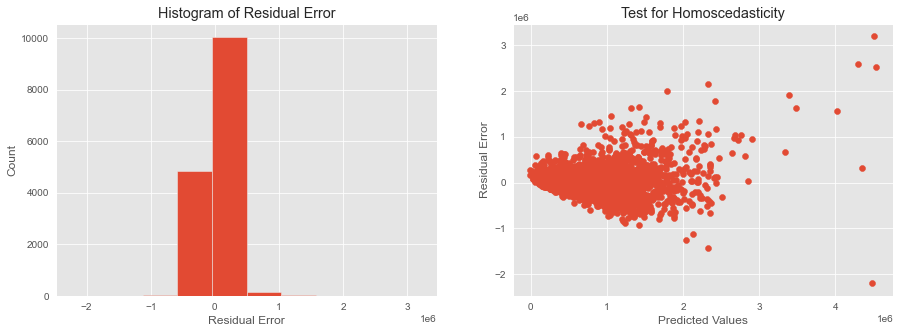

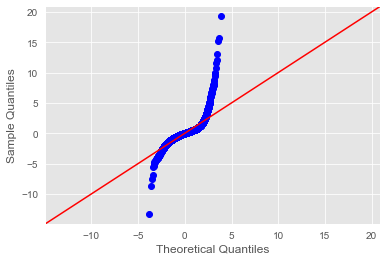

In [91]:
##checking model assumptions
p = sns.distplot(final_model.resid);
plt.xlabel("Residual Error", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
p.set_title("Distribution of Residual Error");

resid = final_model.resid

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(resid)
ax[0].set_xlabel("Residual Error")
ax[0].set_ylabel("Count")
ax[0].set_title(label="Histogram of Residual Error");

ax[1].scatter(x=final_model.fittedvalues,y=resid)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residual Error")
ax[1].set_title(label="Test for Homoscedasticity")

plt.style.use('ggplot')
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True);

## Observations
- looks we came up with our best model. 
- Its a combination of the following features:
    1. sqft_living
    2. waterfront
    3. bedrooms
    4. was_renovated
    5. bed_bath_ratio
    6. ratio_sqft_living_lot
    7. sqft_living_to_bathroom_ratio
    8. condition
    9. zipcodes

Now let's check our assumptions:
 - There is a linear relationship between our dependant and indepedenant variables
 - Residuals are evenly spread across range of predicted values
 - Model residuals follow a normal distribution
 - Our relevant coeficients are statistically significant
 - We have some issues with co-linearity based on our Cond. No (1.63e+05)


## Test sample with final model
- transforming our sample the way we transformed our training dataset.
- Using our test sample and seeing how accurate our model is**

In [92]:
#creating new numeric df from our train split
X_test_numeric =X_test.filter(['bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                                    'sqft_above','yr_built','yr_renovated','lat','long','sqft_living15',
                                    'sqft_lot15','sqft_basement2','Distance_to_Water' ], axis=1)
X_test_numeric.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6480 entries, 7842 to 9367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           6480 non-null   int64  
 1   bathrooms          6480 non-null   float64
 2   sqft_living        6480 non-null   int64  
 3   sqft_lot           6480 non-null   int64  
 4   floors             6480 non-null   float64
 5   sqft_above         6480 non-null   int64  
 6   yr_built           6480 non-null   int64  
 7   yr_renovated       6480 non-null   int64  
 8   lat                6480 non-null   float64
 9   long               6480 non-null   float64
 10  sqft_living15      6480 non-null   int64  
 11  sqft_lot15         6480 non-null   int64  
 12  sqft_basement2     6480 non-null   int64  
 13  Distance_to_Water  6480 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 759.4 KB


In [93]:
X_test['waterfront'].value_counts()

False    6443
True       37
Name: waterfront, dtype: int64

In [94]:
#take boolean column of 'waterfront' and encode
waterfront_test = X_test[["waterfront"]]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]

array([False,  True])

In [95]:
#flattening
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_test.flatten()
waterfront_encoded_test

array([0., 0., 0., ..., 0., 0., 0.])

In [96]:
#replacing values and checking
X_test["waterfront"] = waterfront_encoded_test
X_test.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,was_renovated,Distance_to_Water,bed_bath_ratio,bath_bed_ratio,sqft_living_to_bedroom_ratio,sqft_living_to_bathroom_ratio,ratio_sqft_lot_living,ratio_sqft_living_lot,age_at_sale,age_renovation_at_sale
7842,8005100360,3,1.00,910,5800,1.5,0.0,NONE,Good,5 Fair,...,False,0.768487,3.000000,0.333333,303.333333,910.000000,6.373626,0.156897,114,114
8845,7504100590,4,2.25,3180,9600,2.0,0.0,NONE,Average,10 Very Good,...,False,0.201579,1.777778,0.562500,795.000000,1413.333333,3.018868,0.331250,31,31
15392,2880100795,3,2.50,2350,3750,2.0,0.0,NONE,Average,7 Average,...,False,1.162583,1.200000,0.833333,783.333333,940.000000,1.595745,0.626667,11,11
2768,5315100394,3,1.00,1440,13824,1.0,0.0,NONE,Good,7 Average,...,False,0.367528,3.000000,0.333333,480.000000,1440.000000,9.600000,0.104167,58,58
5909,4206901155,3,2.00,2168,4000,1.5,0.0,NONE,Average,8 Good,...,False,0.183710,1.500000,0.666667,722.666667,1084.000000,1.845018,0.542000,107,107


In [97]:
#checking newly created values for waterfront feature
X_test['waterfront'].value_counts()

0.0    6443
1.0      37
Name: waterfront, dtype: int64

In [98]:
##getting values for was_renovated feature
X_test['was_renovated'].value_counts()

False    6244
True      236
Name: was_renovated, dtype: int64

In [99]:
#take boolean column of 'was_renovated', encoding, and flattening
was_renovated_test = X_test[["was_renovated"]]
encoder_was_renovated = OrdinalEncoder()
encoder_was_renovated.fit(was_renovated_test)
was_renovated_encoded_test = encoder_was_renovated.transform(was_renovated_test)
was_renovated_encoded_test = was_renovated_encoded_test.flatten()
was_renovated_encoded_test
#replacing in X_test
X_test["was_renovated"] = was_renovated_encoded_test
X_test.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,was_renovated,Distance_to_Water,bed_bath_ratio,bath_bed_ratio,sqft_living_to_bedroom_ratio,sqft_living_to_bathroom_ratio,ratio_sqft_lot_living,ratio_sqft_living_lot,age_at_sale,age_renovation_at_sale
7842,8005100360,3,1.00,910,5800,1.5,0.0,NONE,Good,5 Fair,...,0.0,0.768487,3.000000,0.333333,303.333333,910.000000,6.373626,0.156897,114,114
8845,7504100590,4,2.25,3180,9600,2.0,0.0,NONE,Average,10 Very Good,...,0.0,0.201579,1.777778,0.562500,795.000000,1413.333333,3.018868,0.331250,31,31
15392,2880100795,3,2.50,2350,3750,2.0,0.0,NONE,Average,7 Average,...,0.0,1.162583,1.200000,0.833333,783.333333,940.000000,1.595745,0.626667,11,11
2768,5315100394,3,1.00,1440,13824,1.0,0.0,NONE,Good,7 Average,...,0.0,0.367528,3.000000,0.333333,480.000000,1440.000000,9.600000,0.104167,58,58
5909,4206901155,3,2.00,2168,4000,1.5,0.0,NONE,Average,8 Good,...,0.0,0.183710,1.500000,0.666667,722.666667,1084.000000,1.845018,0.542000,107,107


In [100]:
#checking newly created values for was_renovated feature
X_test['was_renovated'].value_counts()

0.0    6244
1.0     236
Name: was_renovated, dtype: int64

In [101]:
#getting values for zipcode feature
X_test['zipcode'].value_counts()

98103    177
98117    173
98052    167
98042    165
98034    160
        ... 
98070     33
98102     28
98024     23
98148     15
98039     11
Name: zipcode, Length: 70, dtype: int64

In [102]:
##getting values for condition feature
X_test['condition'].value_counts()

Average      4226
Good         1706
Very Good     484
Fair           52
Poor           12
Name: condition, dtype: int64

In [103]:
#lets drop all columns we're not using,
X_test.drop(X_test.columns[[5, 7, 9,14, 15, 16, 17]], axis = 1, inplace = True)
#sanity check
X_test.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
       'condition', 'sqft_above', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_basement2', 'was_renovated', 'Distance_to_Water',
       'bed_bath_ratio', 'bath_bed_ratio', 'sqft_living_to_bedroom_ratio',
       'sqft_living_to_bathroom_ratio', 'ratio_sqft_lot_living',
       'ratio_sqft_living_lot', 'age_at_sale', 'age_renovation_at_sale'],
      dtype='object')

In [104]:
#create dummy variables for the "condition" and "zipcode" columns
condition_dummies = pd.get_dummies(X_test['condition'], drop_first=True)
zipcode_dummies = pd.get_dummies(X_test['zipcode'], drop_first=True)

In [105]:
#merging condition and zipcode dummy datasets to X_train
X_test = pd.concat([X_test, condition_dummies, zipcode_dummies], axis=1)
X_test.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,sqft_above,yr_built,yr_renovated,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
7842,8005100360,3,1.00,910,5800,0.0,Good,910,1900,1900,...,0,0,0,0,0,0,0,0,0,0
8845,7504100590,4,2.25,3180,9600,0.0,Average,3180,1984,1984,...,0,0,0,0,0,0,0,0,0,0
15392,2880100795,3,2.50,2350,3750,0.0,Average,1740,2003,2003,...,0,0,0,0,0,0,0,0,0,0
2768,5315100394,3,1.00,1440,13824,0.0,Good,1440,1957,1957,...,0,0,0,0,0,0,0,0,0,0
5909,4206901155,3,2.00,2168,4000,0.0,Average,2168,1907,1907,...,0,0,0,0,0,0,0,0,0,0


In [106]:
#dropping condition and zipcode original columns
X_test.drop(['condition', 'zipcode'], axis = 1, inplace = True)

In [107]:
ss = StandardScaler()
ss.fit(X_test)
X_test_scaled = ss.transform(X_test)

In [108]:
X_test_final = X_test.filter(['sqft_living', 'waterfront','bedrooms', 'was_renovated', 'bed_bath_ratio',
                                'ratio_sqft_living_lot','sqft_living_to_bathroom_ratio', 'Fair', 'Good', 'Poor',
                                'Very Good', '98002', '98003', '98004', '98005',
                           '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
                           '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
                           '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98052',
                            '98053', '98055', '98056', '98058', '98059', '98065', '98070', '98072',
                           '98074', '98075', '98077', '98092', '98102', '98103', '98105', '98106',
                           '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118',
                           '98119', '98122', '98125', '98126', '98133', '98136', '98144', '98146',
                           '98148', '98155', '98166', '98168', '98177', '98178', '98188', '98198', '98199' ], axis=1)

In [109]:
#Scoring our test sample
final_model_test = sm.OLS(y_test, sm.add_constant(X_test_final)).fit()
sm.OLS(y_test, sm.add_constant(X_test_final)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     317.6
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:49:08   Log-Likelihood:                -86889.
No. Observations:                6480   AIC:                         1.739e+05
Df Residuals:                    6399   BIC:                         1.745e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1.811e+04    1.9e+04     -0.955      0.340   -5.53e+04    1.91e+04
sqft_living                     399.2398      7.077     56.416      0.000     385.367     413.112
waterfront                     8.709e+05   2.77e+04     31.421      0.000    8.17e+05    9.25e+05
bedrooms                      -1.146e+05   4877.137    -23.493      0.000   -1.24e+05   -1.05e+05
was_renovated                  2.052e+04    1.1e+04      1.869      0.062   -1002.663     4.2e+04
bed_bath_ratio                 1.591e+05   8333.179     19.091      0.000    1.43e+05    1.75e+05
ratio_sqft_living_lot         -9.538e+04   9867.699     -9.666      0.000   -1.15e+05    -7.6e+04
sqft_living_to_bathroom_ratio  -353.3877     16.376    -21.580      0.000    -385.489    -321.286
Fair                           -2.98e+04   2.29e+04     -1.302      0.193   -7.46e+04    1.51e+04
Good                           8294.7368   5022.038      1.652      0.099   -1550.140    1.81e+04
Poor                          -8.652e+04   4.72e+04     -1.832      0.067   -1.79e+05    6050.246
Very Good                      5.451e+04   8061.656      6.761      0.000    3.87e+04    7.03e+04
98002                          1.485e+04    2.7e+04      0.551      0.582    -3.8e+04    6.77e+04
98003                          7225.7966   2.61e+04      0.277      0.782    -4.4e+04    5.84e+04
98004                          8.351e+05   2.25e+04     37.055      0.000    7.91e+05    8.79e+05
98005                          3.434e+05   2.79e+04     12.315      0.000    2.89e+05    3.98e+05
98006                           3.01e+05   2.09e+04     14.373      0.000     2.6e+05    3.42e+05
98007                          2.998e+05   2.95e+04     10.156      0.000    2.42e+05    3.58e+05
98008                          3.026e+05   2.37e+04     12.743      0.000    2.56e+05    3.49e+05
98010                          4.058e+04    3.1e+04      1.310      0.190   -2.01e+04    1.01e+05
98011                          1.096e+05   2.47e+04      4.432      0.000    6.11e+04    1.58e+05
98014                          6.907e+04   3.24e+04      2.134      0.033    5627.273    1.33e+05
98019                          8.198e+04   2.57e+04      3.184      0.001    3.15e+04    1.32e+05
98022                          4.994e+04   2.55e+04      1.958      0.050     -58.541    9.99e+04
98023                         -3.415e+04   2.07e+04     -1.648      0.099   -7.48e+04    6462.241
98024                           1.59e+05   3.73e+04      4.262      0.000    8.59e+04    2.32e+05
98027                          1.751e+05   2.15e+04      8.133      0.000    1.33e+05    2.17e+05
98028                          1.417e+05   2.31e+04      6.136      0.000    9.64e+04    1.87e+05
98029                          2.298e+05   2.

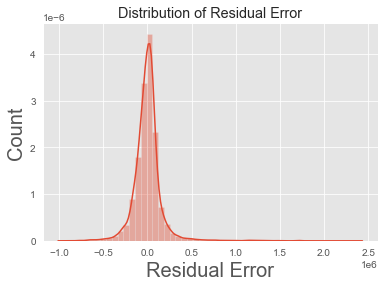

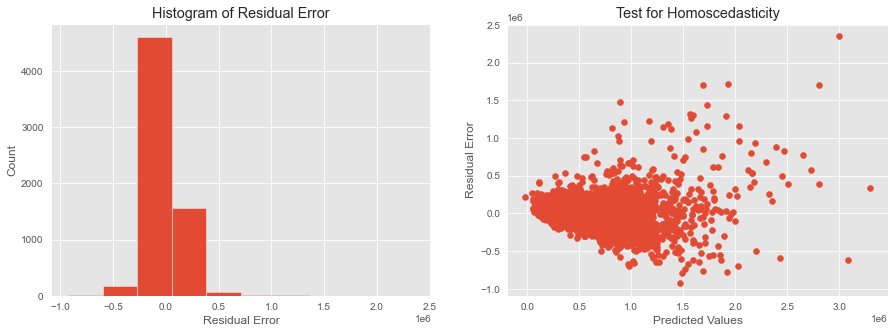

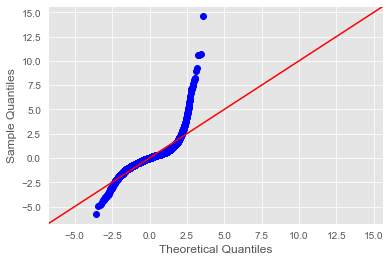

In [110]:
##checking model assumptions
resid = final_model_test.resid

p = sns.distplot(final_model_test.resid);
plt.xlabel("Residual Error", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
p.set_title("Distribution of Residual Error");

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(resid)
ax[0].set_xlabel("Residual Error")
ax[0].set_ylabel("Count")
ax[0].set_title(label="Histogram of Residual Error");

ax[1].scatter(x=final_model_test.fittedvalues,y=resid)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residual Error")
ax[1].set_title(label="Test for Homoscedasticity")

plt.style.use('ggplot')
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True);

In [111]:
print("Final Model")
print("Train score:     ", final_model_scores["train_score"].mean())
print("Validation score:", final_model_scores["test_score"].mean())
print()
print("Model 1C")
print("Train score:     ", multi_model_c_scores["train_score"].mean())
print("Validation score:", multi_model_c_scores["test_score"].mean())
print()
print("Model 1B")
print("Train score:     ", multi_model_b_scores["train_score"].mean())
print("Validation score:", multi_model_b_scores["test_score"].mean())
print()
print("Model 1")
print("Train score:     ", multi_model_scores["train_score"].mean())
print("Validation score:", multi_model_scores["test_score"].mean())

Final Model
Train score:      0.8052720552099978
Validation score: 0.7808099264106492

Model 1C
Train score:      0.8140312189715558
Validation score: 0.790276473842936

Model 1B
Train score:      0.57246679345766
Validation score: 0.5528461425859618

Model 1
Train score:      0.6334429950650039
Validation score: 0.6099003027567962


In [112]:
#calculate our root-mean-sqaured error
final_model_test_lr = LinearRegression()
final_model_test_lr.fit(X_test_final,y_test)
mean_squared_error(y_test,final_model_test_lr.predict(X_test_final),squared=False)

161112.39667047764

## Visualizations

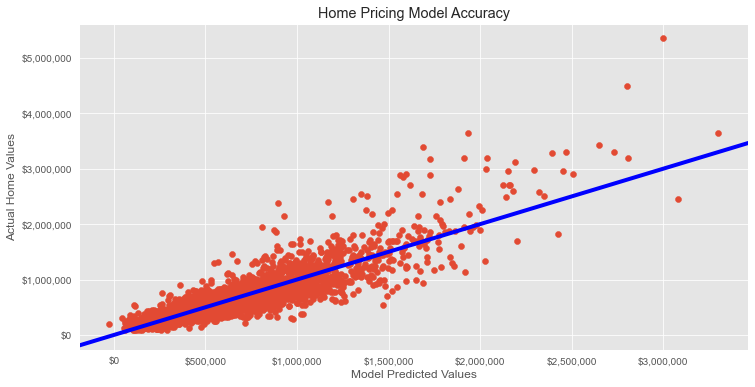

In [113]:
#Chart of our model accuracy
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(x=final_model_test.fittedvalues,y=y_test)
ax.axline((0, 0), (1, 1), linewidth=4, color='b')
ax.ticklabel_format(style='plain')
ax.xaxis.set_major_formatter('${x:,.0f}')
ax.yaxis.set_major_formatter('${x:,.0f}')
#ax.set_ybound(upper=2000000)
#ax.set_xbound(upper=2000000)
ax.set_title("Home Pricing Model Accuracy")
ax.set_xlabel("Model Predicted Values")
ax.set_ylabel("Actual Home Values");
#Save figure
plt.savefig('images/Home_Pricing_Model_Accuracy.png', bbox_inches='tight')
#ax.set_xbound;

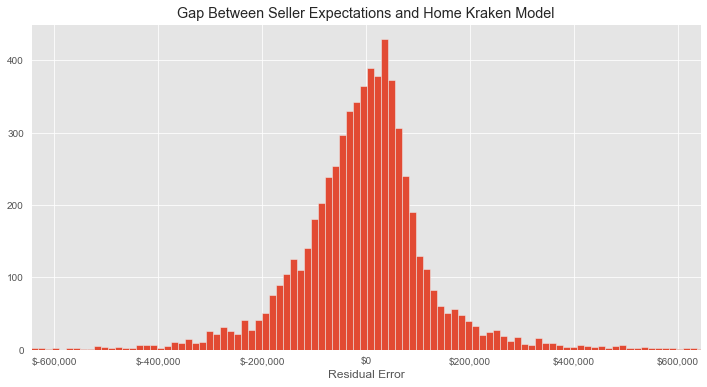

In [114]:
#Chart the residuals from our model 
#Create residual series
#resid_multi_model_5_OLS = multi_model_5_OLS.resid
#Create chart
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(resid,bins="auto")
ax.set_xlabel("Residual Error")
ax.xaxis.set_major_formatter('${x:,.0f}')
ax.set_title(label="Gap Between Seller Expectations and Home Kraken Model")
ax.set_xbound(lower=(resid.std()*-4),upper=resid.std()*4)
plt.savefig('images/Histogram_of_Residual_Error.png', bbox_inches='tight')

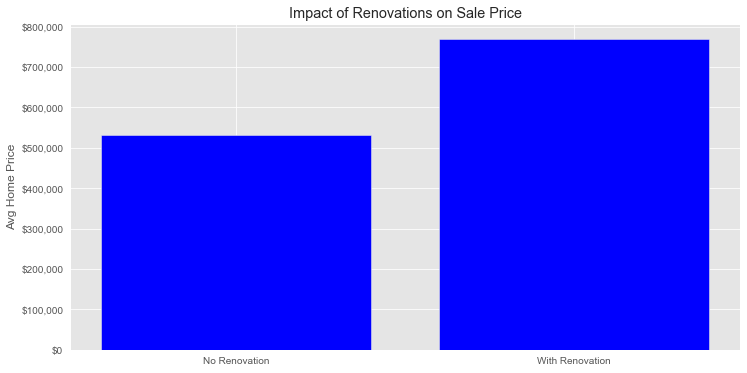

In [115]:
#create a dictionary of for mean price values of each category of renovation; with and without
was_renovated_mean_price_dict = cleaned_housing.groupby(["was_renovated"]).mean()['price'].to_dict()
#Plot mean price values for each category
x = was_renovated_mean_price_dict.keys()
y = was_renovated_mean_price_dict.values()
tick_label = ['False', 'True']
fig, ax = plt.subplots(figsize=(12,6))
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_title("")
ax.bar(x,y,tick_label=["No Renovation","With Renovation"],color="b")
ax.set_title("Impact of Renovations on Sale Price")
ax.set_ylabel("Avg Home Price")
plt.savefig('images/Impact_of_renovations_on_sale_price', bbox_inches='tight');

In [116]:
#Explore mean price by condition
unsorted_condition_mean_price_dict = cleaned_housing.groupby(["condition"]).mean()['price'].sort_values().to_dict()
unsorted_condition_mean_price_dict

{'Fair': 328178.7588235294,
 'Poor': 341067.2413793103,
 'Good': 521374.450413951,
 'Average': 542173.0573466476,
 'Very Good': 612577.7425044092}

In [117]:
#Put our dictionary into intuitive order based on condition
sorted_condition_mean_price_dict = {"Poor":0,"Fair":0,"Average":0,"Good":0,"Very Good":0}
for condition in sorted_condition_mean_price_dict:
    sorted_condition_mean_price_dict[condition] = unsorted_condition_mean_price_dict[condition]

sorted_condition_mean_price_dict

{'Poor': 341067.2413793103,
 'Fair': 328178.7588235294,
 'Average': 542173.0573466476,
 'Good': 521374.450413951,
 'Very Good': 612577.7425044092}

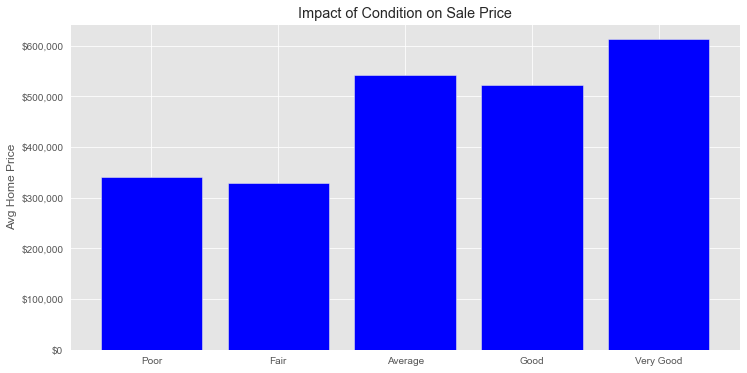

In [118]:
#Plot mean price values of each home condition
x = sorted_condition_mean_price_dict.keys()
y = sorted_condition_mean_price_dict.values()
#tick_label = [x]
fig, ax = plt.subplots(figsize=(12,6))
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_title("")
ax.bar(x,y,color="b")
ax.set_title("Impact of Condition on Sale Price")
ax.set_ylabel("Avg Home Price")

plt.savefig('images/Impact_of_condition_on_sale_price', bbox_inches='tight');

## Conclusion

Our home price prediction model helps improve agency commissions for Every Door Real Estate’s by solving the problem of competing incentives between home seller and listing agency. While traditional approaches to valuing homes can lead to sellers over-valuing their homes and dragging out the sale process as a result, our home prediction model prices homes to sell which improves the volume of sales the agency is able to process. Our model provides statistical backing to agents as they push back on unrealistic client expectations. Additionally, our model identifies categories of home improvement that boost a home’s value which improves client satisfaction and commission value. 


### Data
To build a model suited for the demands of Every Door Real Estate, a Seattle based real estate agency, we analyzed a data set of 22K home sales from the Seattle Metro area between 2014 and 2015.

Model Approach
Knowing the model would be deployed by agents in their work with homeowners, we needed to produce a model that agents could use to accurately estimate the value of a client’s home and provide insight into what factors led to their estimate while pointing to potential home improvements to boost the predicted value. We tested 7 iterations of our model looking for the right combination of home attributes to give us a balance these factors
- Prediction accuracy (R2)
- Prediction precision (variance between train & test)
- Statistical significance (p-values of our coefficients)
- Alignment with assumptions of linear regressions
- *  Linearity: linear relationship between the response variable (Y) and predictor (X)
- *  Homoscedasticity: residuals are evenly spread across range of predicted values
- *  Independence: observations are independent of each other
- *  Normality: model residuals should follow a normal distribution
- *  Ability to draw inferential conclusions from the coefficients
- *  Coefficients that were in the purview of homeowners to improve

Our final model included the features; 'sqft_living', 'waterfront','bedrooms', 'was_renovated', 'bed_bath_ratio','ratio_sqft_living_lot','sqft_living_to_bathroom_ratio', 'condition', and 'zipcode'

### Model Results
Our final model has an mean R2 of 0.81 and 0.78 for the train and test respectively giving the Every Door Real Estate the power to predict about 80% of the fluctuation in home value based on criteria they pass into the model. Our root mean squared error is $ 161,112 meaning our home price prediction off by \\$161,112 on average which is reasonable given the range of home prices we trained our data on (\\$78 K to \\$7.7MM). Our model is precise with small differences in the R2 between our train and test split. Each of our model coefficients are statistically significant with P-values significantly less than 0.05 Our model conforms with each of the assumptions for linear regressions except some issues with colinearity


### Limitations & Next Steps
Our model has a 20% error. With further feature engineering we could reduce our error and create a more predictive model. Specifically, we would further explore the interaction between home condition and renovation to eliminate potential collinearity.

As mentioned in our introduction, we analyzed 1 year of sales data from 2014 to 2015, with additional and more recent data we could update the model to be more relevant to today’s market. 

With additional input from Open Door, we could further limit the scope of the model to focus on their target market which would produce a more limited but more accurate model.
